In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/ST/stargan

Mounted at /content/drive
/content/drive/MyDrive/ST/stargan


In [2]:
dataset = 'realworld_mobiact' # 'realworld' or 'cwru' or 'realworld_mobiact'

# Pre-trained Networks

## Domain Classifiers

In [3]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
import os

seed = 2710
np.random.seed(seed)
torch.manual_seed(seed)

class MultiBranchClassifier(nn.Module):
    def __init__(self, num_channels=3, num_domains=4, num_classes=5, num_timesteps=128):
        super(MultiBranchClassifier, self).__init__()
        # Shared layers as before
        self.conv1 = nn.Conv1d(num_channels, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.fc_shared = nn.Linear(num_timesteps * 8, 100)

        # Prepare class-specific branches as a single module with conditionally applied outputs
        self.fc_class_branches = nn.Linear(100, 50 * num_classes)
        self.fc_final = nn.Linear(50, num_domains * num_classes)

    def forward(self, x, class_ids):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc_shared(x))

        # Process all class-specific branches simultaneously
        class_branches = self.fc_class_branches(x).view(x.size(0), -1, 50)
        class_outputs = class_branches[torch.arange(class_branches.size(0)), class_ids]

        # Final class-specific output
        final_outputs = self.fc_final(class_outputs.view(x.size(0), 50))
        return final_outputs.view(x.size(0), -1)


def split_data(x, y, k, test_size=0.2, random_state=seed):
    x_train, x_test, y_train, y_test, k_train, k_test = train_test_split(x, y, k,
                                                                         test_size=test_size,
                                                                         random_state=random_state,
                                                                         stratify=k,
                                                                         shuffle=True)
    return x_train, x_test, y_train, y_test, k_train, k_test


def setup_training(x_train, y_train, k_train, x_test, y_test, k_test, batch_size=64):
    # Convert numpy arrays to torch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    k_train_tensor = torch.tensor(k_train, dtype=torch.long)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    k_test_tensor = torch.tensor(k_test, dtype=torch.long)

    # Create datasets and loaders
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor, k_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor, k_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader


def evaluate_model(model, test_loader, loss_fn, device='cpu'):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for x_batch, y_batch, k_batch in test_loader:
            x_batch, y_batch, k_batch = x_batch.to(device), y_batch.to(device), k_batch.to(device)
            outputs = model(x_batch, y_batch)
            loss = loss_fn(outputs, k_batch)
            total_loss += loss.item()

            # Assuming outputs are logits and k_batch are the true labels
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions += (predicted_labels == k_batch).sum().item()
            total_predictions += k_batch.size(0)

    total_loss /= len(test_loader)
    accuracy = correct_predictions / total_predictions

    return total_loss, accuracy


def train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=300, name='domain_classifier'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loss_train = []
    loss_test = []
    accuracy_test = []
    best_loss = np.inf

    # Set up linear learning rate decay
    lambda_lr = lambda epoch: 1 - epoch / epochs
    scheduler = LambdaLR(optimizer, lr_lambda=lambda_lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch, k_batch in train_loader:
            x_batch, y_batch, k_batch = x_batch.to(device), y_batch.to(device), k_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch, y_batch)
            loss = loss_fn(outputs, k_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        total_loss /= len(train_loader)
        loss_train.append(total_loss)

        # Update learning rate
        scheduler.step()

        test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn, device=device)
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model.state_dict().copy()
        loss_test.append(test_loss)
        accuracy_test.append(test_accuracy)

        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch + 1}/{epochs} - Train loss: {total_loss:.4f} - Test loss: {test_loss:.4f} - Test accuracy: {test_accuracy:.4f} - LR: {current_lr:.6f}")

    # Save best model
    os.makedirs('pretrained_nets', exist_ok=True)
    if best_model is not None:
        print(f"Saving best model at epoch {np.argmin(loss_test) + 1} and test loss {best_loss:.4f}")
        torch.save(best_model, f"pretrained_nets/{name}.ckpt")
    else:
        print("No best model found, saving current model")
        torch.save(model.state_dict(), f"pretrained_nets/{name}.ckpt")

    return loss_train, loss_test, accuracy_test

(11783, 3, 128) (11783,) (11783,)
(9426, 3, 128) (2357, 3, 128) (9426,) (2357,) (9426,) (2357,)
Epoch 1/300 - Train loss: 3.2502 - Test loss: 2.3280 - Test accuracy: 0.3123 - LR: 0.000100
Epoch 2/300 - Train loss: 1.8898 - Test loss: 1.5201 - Test accuracy: 0.5634 - LR: 0.000099
Epoch 3/300 - Train loss: 1.3151 - Test loss: 1.1075 - Test accuracy: 0.7238 - LR: 0.000099
Epoch 4/300 - Train loss: 0.9699 - Test loss: 0.8178 - Test accuracy: 0.7913 - LR: 0.000099
Epoch 5/300 - Train loss: 0.7267 - Test loss: 0.6181 - Test accuracy: 0.8485 - LR: 0.000098
Epoch 6/300 - Train loss: 0.5525 - Test loss: 0.4806 - Test accuracy: 0.8761 - LR: 0.000098
Epoch 7/300 - Train loss: 0.4371 - Test loss: 0.4022 - Test accuracy: 0.8935 - LR: 0.000098
Epoch 8/300 - Train loss: 0.3566 - Test loss: 0.3335 - Test accuracy: 0.9071 - LR: 0.000097
Epoch 9/300 - Train loss: 0.2905 - Test loss: 0.2951 - Test accuracy: 0.9181 - LR: 0.000097
Epoch 10/300 - Train loss: 0.2559 - Test loss: 0.2687 - Test accuracy: 0.921

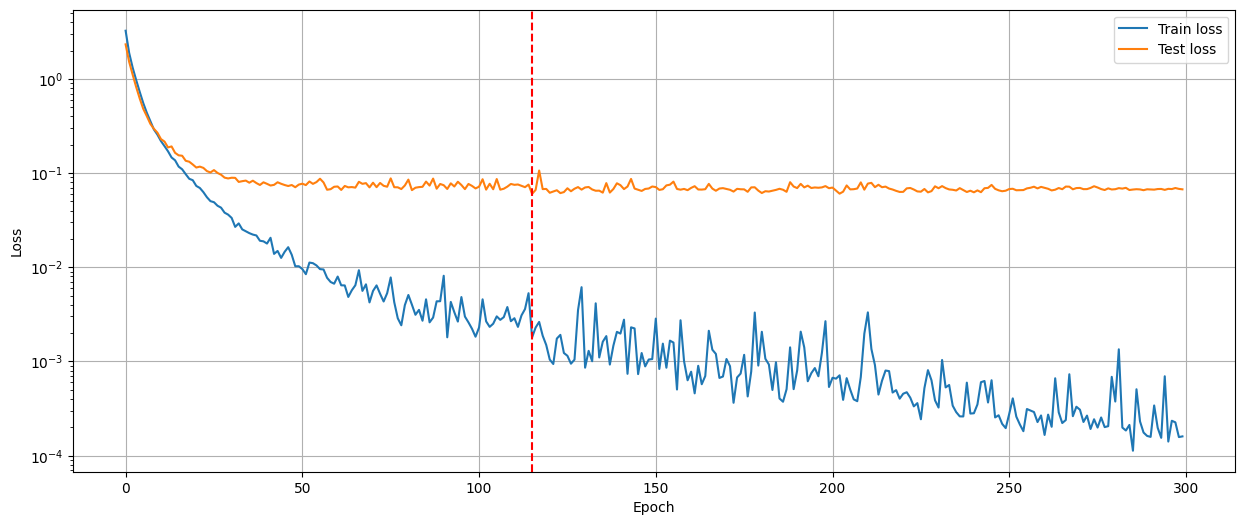

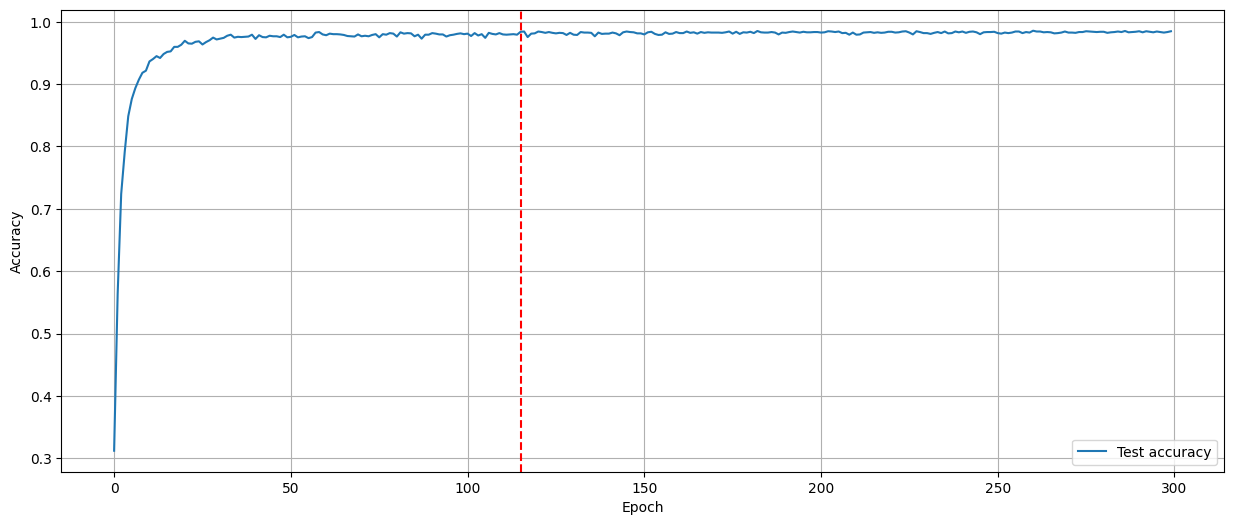

In [4]:
# Train domain classifier on Df

if dataset == 'realworld':
    dataset_name = 'realworld_128_3ch_4cl'
    num_df_domains = 10
    num_dp_domains = 5
    num_classes = 4

elif dataset == 'cwru':
    dataset_name = 'cwru_256_3ch_5cl'
    num_df_domains = 4
    num_dp_domains = 4
    num_classes = 5

elif dataset == 'realworld_mobiact':
    dataset_name = 'realworld_mobiact'
    num_df_domains = 15
    num_dp_domains = 61
    num_classes = 4


with open(f'data/{dataset_name}.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

x = x[k < num_df_domains]
y = y[k < num_df_domains]
k = k[k < num_df_domains]
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchClassifier(num_domains=num_df_domains, num_classes=num_classes, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

loss_fn = nn.CrossEntropyLoss()

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, accuracy_test = train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=300, name=f'domain_classifier_{dataset}_df')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Test accuracy: {accuracy_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the test accuracy
plt.figure(figsize=(15, 6))
plt.plot(accuracy_test, label='Test accuracy')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

(9596, 3, 128) (9596,) (9596,)
(7676, 3, 128) (1920, 3, 128) (7676,) (1920,) (7676,) (1920,)
Epoch 1/300 - Train loss: 5.1087 - Test loss: 4.4862 - Test accuracy: 0.0391 - LR: 0.000100
Epoch 2/300 - Train loss: 4.0137 - Test loss: 3.6436 - Test accuracy: 0.1417 - LR: 0.000099
Epoch 3/300 - Train loss: 3.3320 - Test loss: 3.0731 - Test accuracy: 0.2979 - LR: 0.000099
Epoch 4/300 - Train loss: 2.7667 - Test loss: 2.5451 - Test accuracy: 0.3964 - LR: 0.000099
Epoch 5/300 - Train loss: 2.2611 - Test loss: 2.0721 - Test accuracy: 0.5557 - LR: 0.000098
Epoch 6/300 - Train loss: 1.8348 - Test loss: 1.7013 - Test accuracy: 0.6531 - LR: 0.000098
Epoch 7/300 - Train loss: 1.4912 - Test loss: 1.4146 - Test accuracy: 0.7193 - LR: 0.000098
Epoch 8/300 - Train loss: 1.2581 - Test loss: 1.2187 - Test accuracy: 0.7484 - LR: 0.000097
Epoch 9/300 - Train loss: 1.0681 - Test loss: 1.0758 - Test accuracy: 0.7734 - LR: 0.000097
Epoch 10/300 - Train loss: 0.9216 - Test loss: 0.9535 - Test accuracy: 0.7958 -

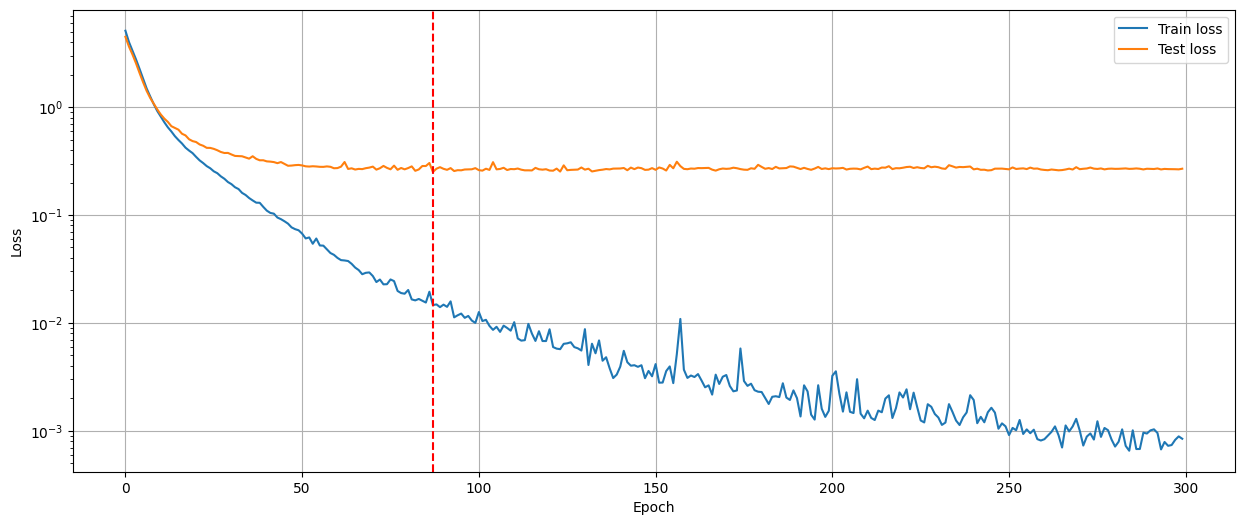

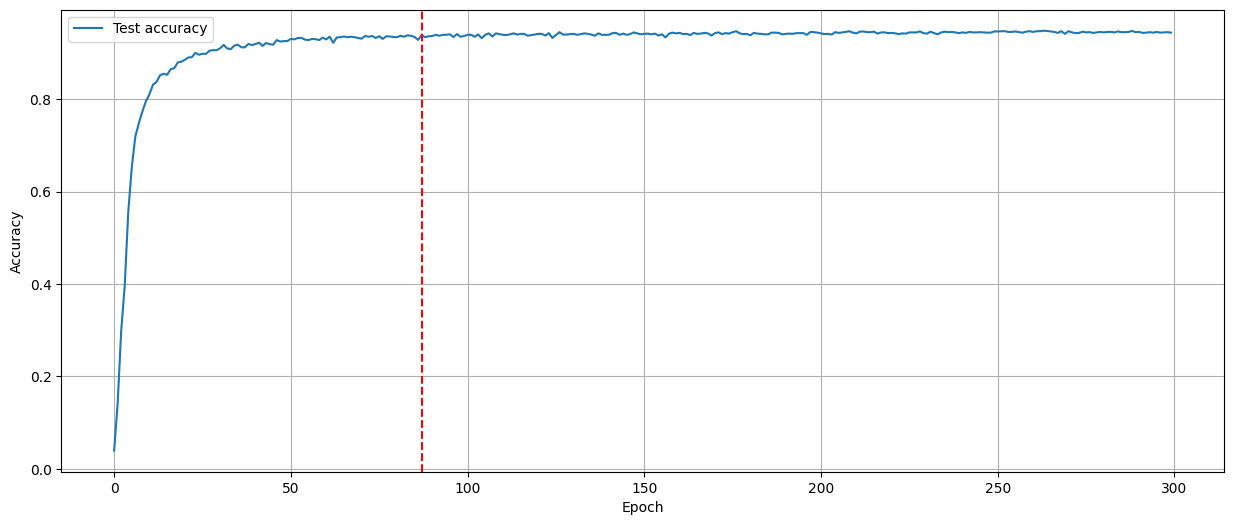

In [5]:
# Train domain classifier on Dp

with open(f'data/{dataset_name}.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

with open(f'data/{dataset_name}_fs.pkl', 'rb') as f:
    fs = pickle.load(f)

x = x[fs == 0]
y = y[fs == 0]
k = k[fs == 0]
x = x[k >= num_df_domains]
y = y[k >= num_df_domains]
k = k[k >= num_df_domains] - num_df_domains
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchClassifier(num_domains=num_dp_domains, num_classes=num_classes, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

loss_fn = nn.CrossEntropyLoss()

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, accuracy_test = train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=300, name=f'domain_classifier_{dataset}_dp')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Test accuracy: {accuracy_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the test accuracy
plt.figure(figsize=(15, 6))
plt.plot(accuracy_test, label='Test accuracy')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## Siamese Networks

In [6]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
import os

seed = 2710
np.random.seed(seed)
torch.manual_seed(seed)

class MultiBranchSiameseNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=5, num_timesteps=128):
        super(MultiBranchSiameseNet, self).__init__()
        # Shared layers
        self.conv1 = nn.Conv1d(num_channels, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.fc_shared = nn.Linear(num_timesteps * 8, 100)

        # Class-specific branches
        self.fc_class_branches = nn.Linear(100, 50 * num_classes)

    def forward_once(self, x, class_id):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc_shared(x))

        # Process class-specific branch
        class_branches = self.fc_class_branches(x).view(x.size(0), -1, 50)
        class_output = class_branches[torch.arange(class_branches.size(0)), class_id]
        return class_output


def split_data(x, y, k, test_size=0.2, random_state=seed):
    x_train, x_test, y_train, y_test, k_train, k_test = train_test_split(x, y, k,
                                                                         test_size=test_size,
                                                                         random_state=random_state,
                                                                         stratify=k,
                                                                         shuffle=True)
    return x_train, x_test, y_train, y_test, k_train, k_test


def setup_training(x_train, y_train, k_train, x_test, y_test, k_test, batch_size=64):
    # Convert numpy arrays to torch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    k_train_tensor = torch.tensor(k_train, dtype=torch.long)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    k_test_tensor = torch.tensor(k_test, dtype=torch.long)

    # Create datasets and loaders
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor, k_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor, k_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader


def evaluate_model(model, test_loader, device='cpu', margin=1.0):
    model.eval()
    total_loss = 0
    same_domain_distance = 0
    diff_domain_distance = 0
    same_domain_count = 0
    diff_domain_count = 0

    with torch.no_grad():
        for x_batch, y_batch, k_batch in test_loader:
            x_batch, y_batch, k_batch = x_batch.to(device), y_batch.to(device), k_batch.to(device)
            batch_size = x_batch.size(0)

            # Compute all pairwise outputs
            output1 = model.forward_once(x_batch.unsqueeze(1).expand(-1, batch_size, -1, -1).reshape(-1, x_batch.size(1), x_batch.size(2)),
                                         y_batch.unsqueeze(1).expand(-1, batch_size).reshape(-1))
            output2 = model.forward_once(x_batch.unsqueeze(0).expand(batch_size, -1, -1, -1).reshape(-1, x_batch.size(1), x_batch.size(2)),
                                         y_batch.unsqueeze(0).expand(batch_size, -1).reshape(-1))

            output1 = output1.view(batch_size, batch_size, -1)
            output2 = output2.view(batch_size, batch_size, -1)

            # Compute pairwise distances
            euclidean_distances = F.pairwise_distance(output1, output2, keepdim=True).view(batch_size, batch_size)

            # Compute pairwise labels
            labels = (k_batch.unsqueeze(1) != k_batch.unsqueeze(0)).float()

            # Compute loss
            loss = (1 - labels) * torch.pow(euclidean_distances, 2) + labels * torch.pow(torch.clamp(margin - euclidean_distances, min=0.0), 2)
            total_loss += loss.mean().item()

            # Compute distances for same and different domains
            same_domain_distance += euclidean_distances[labels == 0].sum().item()
            diff_domain_distance += euclidean_distances[labels == 1].sum().item()
            same_domain_count += (labels == 0).sum().item()
            diff_domain_count += (labels == 1).sum().item()

    total_loss /= len(test_loader)
    avg_same_domain_distance = same_domain_distance / same_domain_count if same_domain_count > 0 else 0
    avg_diff_domain_distance = diff_domain_distance / diff_domain_count if diff_domain_count > 0 else 0

    return total_loss, avg_same_domain_distance, avg_diff_domain_distance


def train_model(model, train_loader, test_loader, optimizer, epochs=300, name='siamese_net', margin=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loss_train = []
    loss_test = []
    avg_same_domain_distance_test = []
    avg_diff_domain_distance_test = []
    best_loss = np.inf

    # Set up linear learning rate decay
    lambda_lr = lambda epoch: 1 - epoch / epochs
    scheduler = LambdaLR(optimizer, lr_lambda=lambda_lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch, k_batch in train_loader:
            x_batch, y_batch, k_batch = x_batch.to(device), y_batch.to(device), k_batch.to(device)
            batch_size = x_batch.size(0)

            # Compute all pairwise outputs
            output1 = model.forward_once(x_batch.unsqueeze(1).expand(-1, batch_size, -1, -1).reshape(-1, x_batch.size(1), x_batch.size(2)),
                                         y_batch.unsqueeze(1).expand(-1, batch_size).reshape(-1))
            output2 = model.forward_once(x_batch.unsqueeze(0).expand(batch_size, -1, -1, -1).reshape(-1, x_batch.size(1), x_batch.size(2)),
                                         y_batch.unsqueeze(0).expand(batch_size, -1).reshape(-1))

            output1 = output1.view(batch_size, batch_size, -1)
            output2 = output2.view(batch_size, batch_size, -1)

            # Compute pairwise distances
            euclidean_distances = F.pairwise_distance(output1, output2, keepdim=True).view(batch_size, batch_size)

            # Compute pairwise labels
            labels = (k_batch.unsqueeze(1) != k_batch.unsqueeze(0)).float()

            # Compute loss
            loss = (1 - labels) * torch.pow(euclidean_distances, 2) + labels * torch.pow(torch.clamp(margin - euclidean_distances, min=0.0), 2)
            total_loss += loss.mean().item()

            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()

        total_loss /= len(train_loader)
        loss_train.append(total_loss)

        # Update learning rate
        scheduler.step()

        test_loss, avg_same_domain_distance, avg_diff_domain_distance = evaluate_model(model, test_loader, device=device)
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model.state_dict().copy()
        loss_test.append(test_loss)
        avg_same_domain_distance_test.append(avg_same_domain_distance)
        avg_diff_domain_distance_test.append(avg_diff_domain_distance)

        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch + 1}/{epochs} - Train loss: {total_loss:.4f} - Test loss: {test_loss:.4f} - "
              f"Avg same domain distance: {avg_same_domain_distance:.4f} - Avg diff domain distance: {avg_diff_domain_distance:.4f} - LR: {current_lr:.6f}")

    # Save best model
    os.makedirs('pretrained_nets', exist_ok=True)
    if best_model is not None:
        print(f"Saving best model at epoch {np.argmin(loss_test) + 1} and test loss {best_loss:.4f}")
        torch.save(best_model, f"pretrained_nets/{name}.ckpt")
    else:
        print("No best model found, saving current model")
        torch.save(model.state_dict(), f"pretrained_nets/{name}.ckpt")

    return loss_train, loss_test, avg_same_domain_distance_test, avg_diff_domain_distance_test

(11783, 3, 128) (11783,) (11783,)
(9426, 3, 128) (2357, 3, 128) (9426,) (2357,) (9426,) (2357,)
Epoch 1/200 - Train loss: 0.0931 - Test loss: 0.1055 - Avg same domain distance: 0.5882 - Avg diff domain distance: 0.7565 - LR: 0.000100
Epoch 2/200 - Train loss: 0.0780 - Test loss: 0.0844 - Avg same domain distance: 0.6016 - Avg diff domain distance: 0.8239 - LR: 0.000099
Epoch 3/200 - Train loss: 0.0744 - Test loss: 0.0772 - Avg same domain distance: 0.5836 - Avg diff domain distance: 0.8571 - LR: 0.000099
Epoch 4/200 - Train loss: 0.0695 - Test loss: 0.0685 - Avg same domain distance: 0.5729 - Avg diff domain distance: 0.9055 - LR: 0.000098
Epoch 5/200 - Train loss: 0.0648 - Test loss: 0.0630 - Avg same domain distance: 0.5620 - Avg diff domain distance: 0.9387 - LR: 0.000097
Epoch 6/200 - Train loss: 0.0617 - Test loss: 0.0569 - Avg same domain distance: 0.5513 - Avg diff domain distance: 0.9774 - LR: 0.000097
Epoch 7/200 - Train loss: 0.0572 - Test loss: 0.0518 - Avg same domain dista

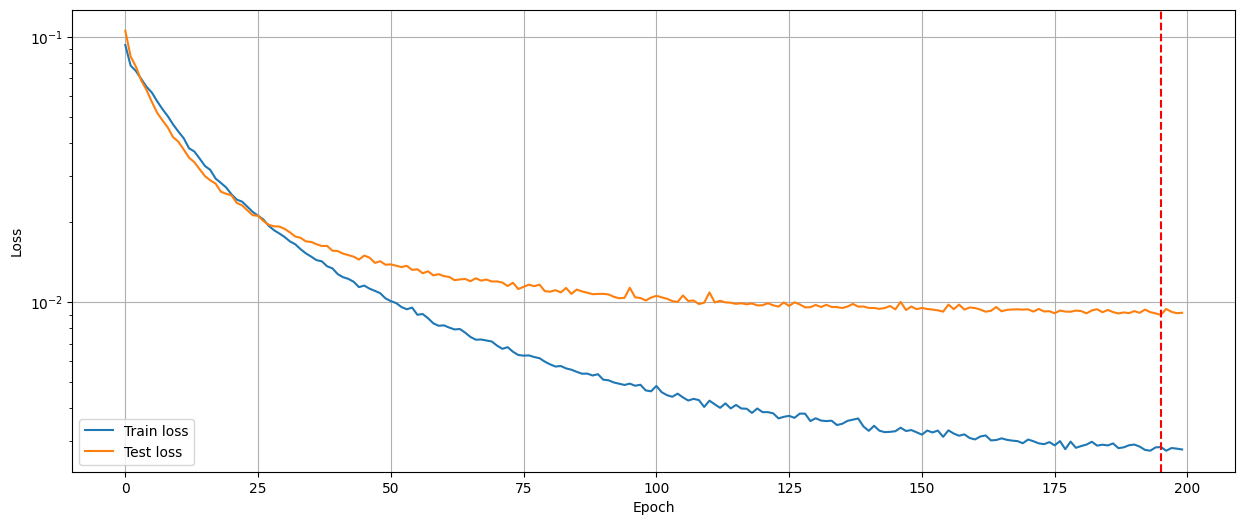

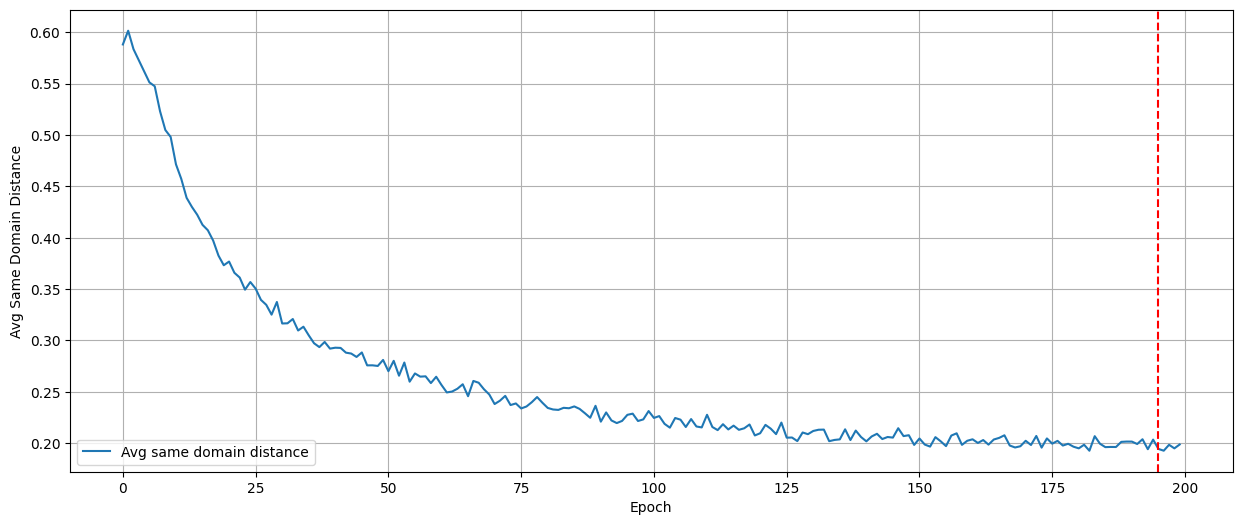

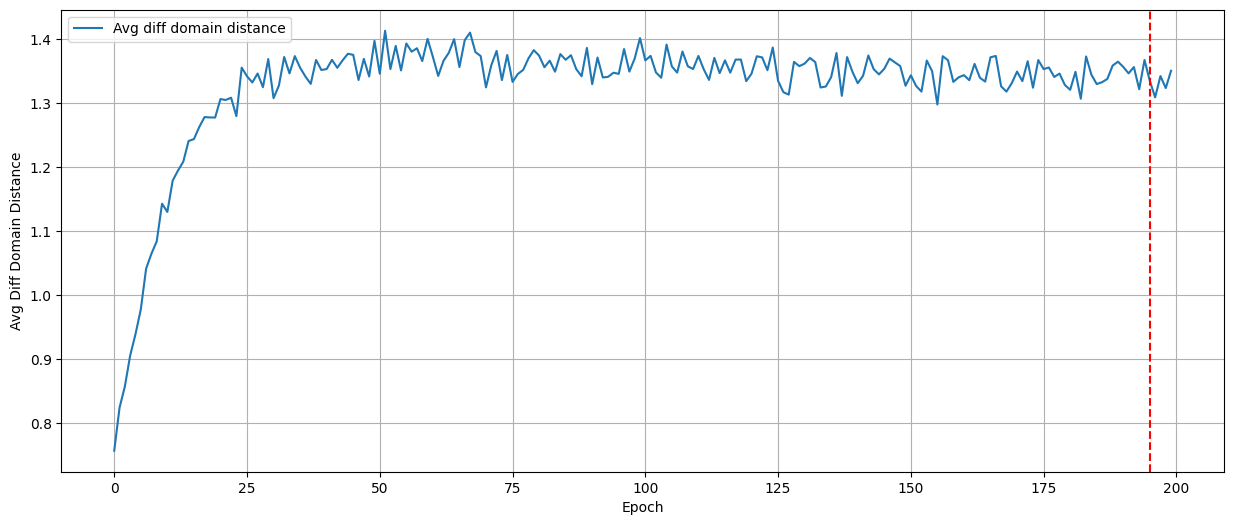

In [7]:
# Train Siamese network on Df

if dataset == 'realworld':
    dataset_name = 'realworld_128_3ch_4cl'
    num_df_domains = 10
    num_dp_domains = 5
    num_classes = 4

elif dataset == 'cwru':
    dataset_name = 'cwru_256_3ch_5cl'
    num_df_domains = 4
    num_dp_domains = 4
    num_classes = 5

elif dataset == 'realworld_mobiact':
    dataset_name = 'realworld_mobiact'
    num_df_domains = 15
    num_dp_domains = 61
    num_classes = 4


with open(f'data/{dataset_name}.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

x = x[k < num_df_domains]
y = y[k < num_df_domains]
k = k[k < num_df_domains]
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchSiameseNet(num_classes=num_classes, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, avg_same_domain_distance_test, avg_diff_domain_distance_test = train_model(model, train_loader, test_loader, optimizer, epochs=200, name=f'siamese_net_{dataset}_df')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Avg same domain distance: {avg_same_domain_distance_test[best_epoch]:.4f} - Avg diff domain distance: {avg_diff_domain_distance_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the average same domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_same_domain_distance_test, label='Avg same domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Same Domain Distance')
plt.legend()
plt.grid()
plt.show()

# Plot the average different domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_diff_domain_distance_test, label='Avg diff domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Diff Domain Distance')
plt.legend()
plt.grid()
plt.show()

(9596, 3, 128) (9596,) (9596,)
(7676, 3, 128) (1920, 3, 128) (7676,) (1920,) (7676,) (1920,)
Epoch 1/200 - Train loss: 0.0343 - Test loss: 0.0324 - Avg same domain distance: 0.3963 - Avg diff domain distance: 0.9647 - LR: 0.000100
Epoch 2/200 - Train loss: 0.0270 - Test loss: 0.0254 - Avg same domain distance: 0.3929 - Avg diff domain distance: 1.0212 - LR: 0.000099
Epoch 3/200 - Train loss: 0.0247 - Test loss: 0.0217 - Avg same domain distance: 0.3914 - Avg diff domain distance: 1.0799 - LR: 0.000099
Epoch 4/200 - Train loss: 0.0231 - Test loss: 0.0190 - Avg same domain distance: 0.3947 - Avg diff domain distance: 1.1410 - LR: 0.000098
Epoch 5/200 - Train loss: 0.0218 - Test loss: 0.0179 - Avg same domain distance: 0.3879 - Avg diff domain distance: 1.1753 - LR: 0.000097
Epoch 6/200 - Train loss: 0.0205 - Test loss: 0.0173 - Avg same domain distance: 0.3792 - Avg diff domain distance: 1.1815 - LR: 0.000097
Epoch 7/200 - Train loss: 0.0192 - Test loss: 0.0165 - Avg same domain distance

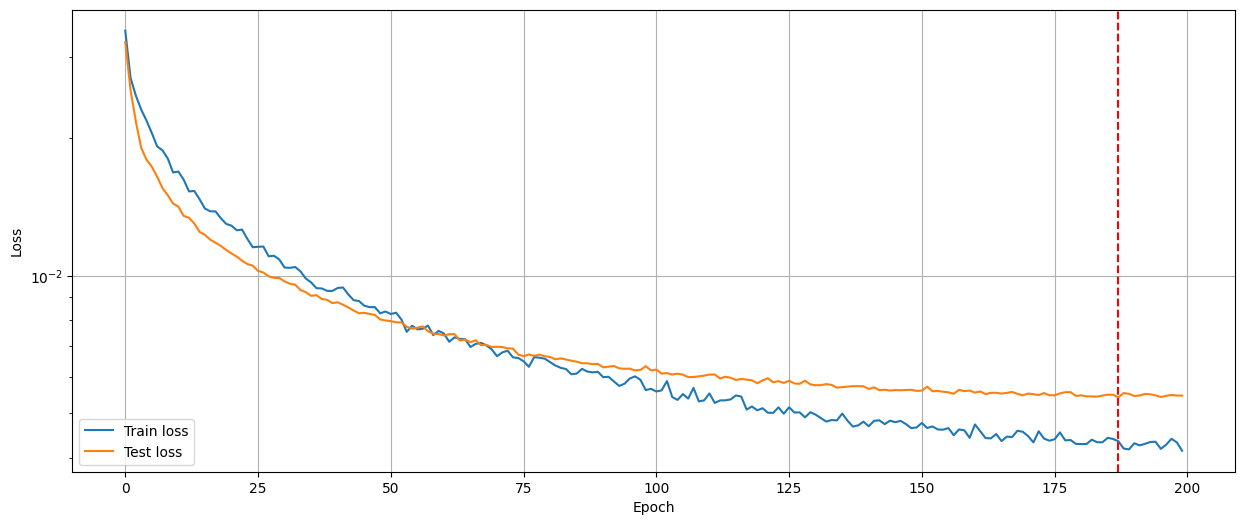

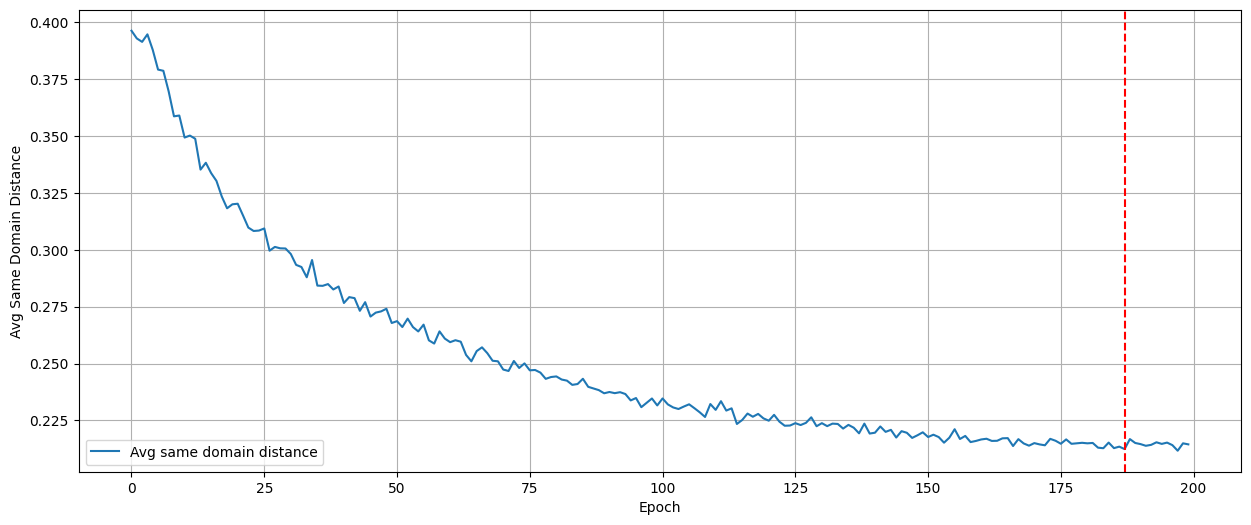

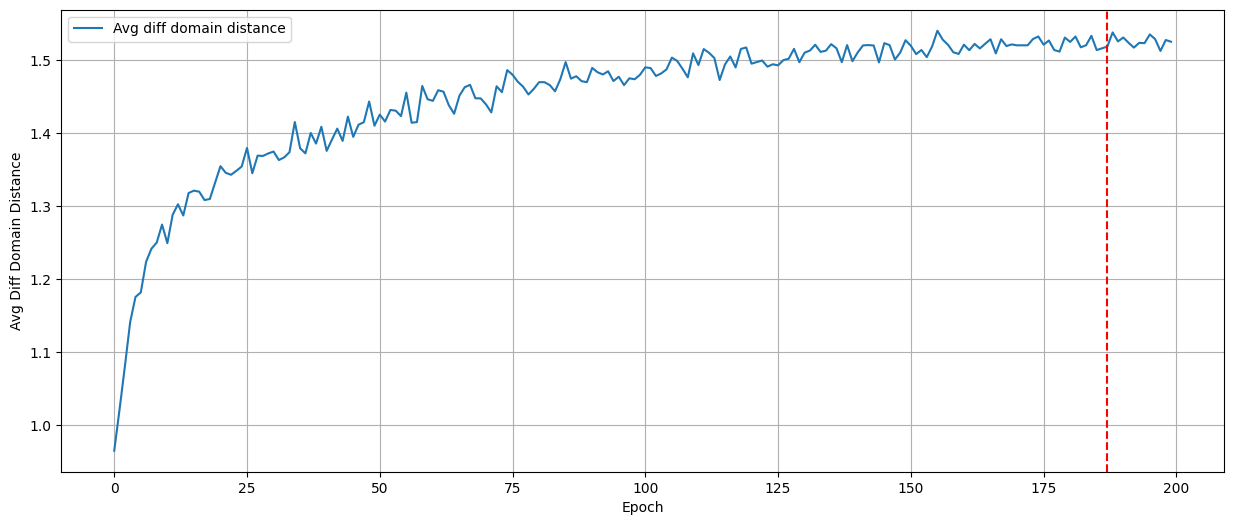

In [8]:
# Train Siamese Network on Dp

with open(f'data/{dataset_name}.pkl', 'rb') as f:
    x, y, k = pickle.load(f)

with open(f'data/{dataset_name}_fs.pkl', 'rb') as f:
    fs = pickle.load(f)

x = x[fs == 0]
y = y[fs == 0]
k = k[fs == 0]
x = x[k >= num_df_domains]
y = y[k >= num_df_domains]
k = k[k >= num_df_domains] - num_df_domains
print(x.shape, y.shape, k.shape)

x_train, x_test, y_train, y_test, k_train, k_test = split_data(x, y, k, test_size=0.2, random_state=seed)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, k_train.shape, k_test.shape)

model = MultiBranchSiameseNet(num_classes=num_classes, num_timesteps=x_train.shape[2])

train_loader, test_loader = setup_training(x_train, y_train, k_train, x_test, y_test, k_test)

initial_lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

loss_train, loss_test, avg_same_domain_distance_test, avg_diff_domain_distance_test = train_model(model, train_loader, test_loader, optimizer, epochs=200, name=f'siamese_net_{dataset}_dp')

# Find the best epoch based on the test loss
best_epoch = np.argmin(loss_test)
print(f"Best epoch: {best_epoch + 1} - Test loss: {loss_test[best_epoch]:.4f} - Avg same domain distance: {avg_same_domain_distance_test[best_epoch]:.4f} - Avg diff domain distance: {avg_diff_domain_distance_test[best_epoch]:.4f}")

# Plot the training and test loss displaying the best epoch with a vertical line
plt.figure(figsize=(15, 6))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_test, label='Test loss')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot the average same domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_same_domain_distance_test, label='Avg same domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Same Domain Distance')
plt.legend()
plt.grid()
plt.show()

# Plot the average different domain distance
plt.figure(figsize=(15, 6))
plt.plot(avg_diff_domain_distance_test, label='Avg diff domain distance')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Avg Diff Domain Distance')
plt.legend()
plt.grid()
plt.show()

# GAN Training

In [ ]:
!pip install munch dask[dataframe]

In [ ]:
import subprocess

if dataset == 'realworld':
    dataset_name = 'realworld_128_3ch_4cl'
    class_names = ['WAL', 'RUN', 'CLD', 'CLU']
    channel_names = ['X', 'Y', 'Z']

    num_timesteps = 128
    num_channels = 3
    num_train_domains = 10
    num_test_domains = 5
    num_classes = 4

    lambda_cyc = 5
    lambda_id = 5
    lambda_dom = 0.1
    lambda_ds = 1

    total_iters = 500000

elif dataset == 'cwru':
    dataset_name = 'cwru_256_3ch_5cl'
    class_names = ['IR', 'Ball', 'OR_centred', 'OR_orthogonal', 'OR_opposite']
    channel_names = ['DE', 'FE', 'BA']

    num_timesteps = 256
    num_channels = 3
    num_train_domains = 4
    num_test_domains = 4
    num_classes = 5

    lambda_cyc = 50
    lambda_id = 50
    lambda_dom = 0.01
    lambda_ds = 1

    total_iters = 500000


print_every = 100
save_every = 10000
sample_every = 1000
eval_every = 10000


# Launch training
print('Starting training phase...\n\n')
subprocess.run(['python', 'main.py',
                '--mode', 'train',
                '--dataset', dataset,
                '--dataset_name', dataset_name,
                '--class_names', ','.join(class_names),
                '--channel_names', ','.join(channel_names),
                '--num_timesteps', str(num_timesteps),
                '--num_channels', str(num_channels),
                '--num_train_domains', str(num_train_domains),
                '--num_test_domains', str(num_test_domains),
                '--num_classes', str(num_classes),
                '--lambda_cyc', str(lambda_cyc),
                '--lambda_id', str(lambda_id),
                '--lambda_dom', str(lambda_dom),
                '--lambda_ds', str(lambda_ds),
                '--print_every', str(print_every),
                '--save_every', str(save_every),
                '--sample_every', str(sample_every),
                '--eval_every', str(eval_every),
                '--total_iters', str(total_iters)
                # '--resume_iter', str(30000),
                ])

# Evaluation

In [ ]:
# Launch evaluation
print('Starting evaluation phase...\n\n')
subprocess.run(['python', 'main.py',
                '--mode', 'eval',
                '--dataset', dataset,
                '--dataset_name', dataset_name,
                '--class_names', ','.join(class_names),
                '--channel_names', ','.join(channel_names),
                '--num_timesteps', str(num_timesteps),
                '--num_channels', str(num_channels),
                '--num_train_domains', str(num_train_domains),
                '--num_test_domains', str(num_test_domains),
                '--num_classes', str(num_classes),
                '--resume_iter', str(total_iters)])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## TSTR Score

In [ ]:
tstr_scores = pd.read_csv(f'expr_{dataset}/eval/tstr_scores.csv')
tstr_scores = tstr_scores.drop(columns=['step', 'loss'])
tstr_scores.head()

tstr_scores_ref = tstr_scores[tstr_scores['mode'] == 'reference']

print('Reference TSTR Scores:')
for source in tstr_scores_ref['source'].unique():
    print(f"Source: {source}")
    for domain in tstr_scores_ref['domain'].unique():
        acc = tstr_scores_ref[(tstr_scores_ref['source'] == source) & (tstr_scores_ref['domain'] == domain)]['accuracy'].values[0]
        print(f"\tDomain: {domain}, Accuracy: {acc:.2f}")

print('\n')

print('Average TSTR Scores:')
for source in tstr_scores_ref['source'].unique():
    acc = tstr_scores_ref[tstr_scores_ref['source'] == source]['accuracy'].mean()
    print(f"Source: {source}, Average Accuracy: {acc:.2f}")

print('\n')

acc = tstr_scores_ref['accuracy'].mean()
print(f"Average Accuracy: {acc:.2f}")

print('\n\n')

tstr_scores_lat = tstr_scores[tstr_scores['mode'] == 'latent']

print('Latent TSTR Scores:')
for source in tstr_scores_lat['source'].unique():
    print(f"Source: {source}")
    for domain in tstr_scores_lat['domain'].unique():
        acc = tstr_scores_lat[(tstr_scores_lat['source'] == source) & (tstr_scores_lat['domain'] == domain)]['accuracy'].values[0]
        print(f"\tDomain: {domain}, Accuracy: {acc:.2f}")

print('\n')

print('Average TSTR Scores:')
for source in tstr_scores_lat['source'].unique():
    acc = tstr_scores_lat[tstr_scores_lat['source'] == source]['accuracy'].mean()
    print(f"Source: {source}, Average Accuracy: {acc:.2f}")

print('\n')

acc = tstr_scores_lat['accuracy'].mean()
print(f"Average Accuracy: {acc:.2f}")

## Domain Score

In [ ]:
domain_scores = pd.read_csv(f'expr_{dataset}/eval/domain_scores.csv')
domain_scores = domain_scores.drop(columns=['step', 'loss'])

domain_scores_ref = domain_scores[domain_scores['mode'] == 'reference']

print('Reference Domain Scores:')
for source in domain_scores_ref['source'].unique():
    print(f"Source: {source}")
    for target in domain_scores_ref['target'].unique():
        if source == target:
            continue
        acc = domain_scores_ref[(domain_scores_ref['source'] == source) & (domain_scores_ref['target'] == target)]['accuracy'].values[0]
        print(f"\tTarget: {target}, Accuracy: {acc:.2f}")

print('\n')

print('Average Domain Scores:')
for source in domain_scores_ref['source'].unique():
    acc = domain_scores_ref[domain_scores_ref['source'] == source]['accuracy'].mean()
    print(f"Source: {source}, Average Accuracy: {acc:.2f}")

print('\n')

acc = domain_scores_ref['accuracy'].mean()
print(f"Average Accuracy: {acc:.2f}")

print('\n\n')

domain_scores_lat = domain_scores[domain_scores['mode'] == 'latent']

print('Latent Domain Scores:')
for source in domain_scores_lat['source'].unique():
    print(f"Source: {source}")
    for target in domain_scores_lat['target'].unique():
        if source == target:
            continue
        acc = domain_scores_lat[(domain_scores_lat['source'] == source) & (domain_scores_lat['target'] == target)]['accuracy'].values[0]
        print(f"\tTarget: {target}, Accuracy: {acc:.2f}")

print('\n')

print('Average Domain Scores:')
for source in domain_scores_lat['source'].unique():
    acc = domain_scores_lat[domain_scores_lat['source'] == source]['accuracy'].mean()
    print(f"Source: {source}, Average Accuracy: {acc:.2f}")

print('\n')

acc = domain_scores_lat['accuracy'].mean()
print(f"Average Accuracy: {acc:.2f}")

## Distance Score

In [ ]:
distance_scores = pd.read_csv(f'expr_{dataset}/eval/dist_scores.csv')
distance_scores = distance_scores.drop(columns=['step'])

distance_scores_ref = distance_scores[distance_scores['mode'] == 'reference']

print('Reference Distance Scores:')
for source in distance_scores_ref['source'].unique():
    print(f"Source: {source}")
    for target in distance_scores_ref['target'].unique():
        if source == target:
            continue
        print(f"\tTarget: {target}")
        for domain in distance_scores_ref['domain'].unique():
            dist = distance_scores_ref[(distance_scores_ref['source'] == source) & (distance_scores_ref['target'] == target) & (distance_scores_ref['domain'] == domain)]['distance'].values[0]
            print(f"\t\tDomain: {domain}, Distance: {dist:.2f}")

print('\n')

print('Average Distance Scores:')
for source in distance_scores_ref['source'].unique():
    dist = distance_scores_ref[distance_scores_ref['source'] == source]['distance'].mean()
    print(f"Source: {source}, Average Distance: {dist:.2f}")

print('\n')

dist = distance_scores_ref['distance'].mean()
print(f"Average Distance: {dist:.2f}")

print('\n\n')

distance_scores_lat = distance_scores[distance_scores['mode'] == 'latent']

print('Latent Distance Scores:')
for source in distance_scores_lat['source'].unique():
    print(f"Source: {source}")
    for target in distance_scores_lat['target'].unique():
        if source == target:
            continue
        print(f"\tTarget: {target}")
        for domain in distance_scores_lat['domain'].unique():
            dist = distance_scores_lat[(distance_scores_lat['source'] == source) & (distance_scores_lat['target'] == target) & (distance_scores_lat['domain'] == domain)]['distance'].values[0]
            print(f"\t\tDomain: {domain}, Distance: {dist:.2f}")

print('\n')

print('Average Distance Scores:')
for source in distance_scores_lat['source'].unique():
    dist = distance_scores_lat[distance_scores_lat['source'] == source]['distance'].mean()
    print(f"Source: {source}, Average Distance: {dist:.2f}")

print('\n')

dist = distance_scores_lat['distance'].mean()
print(f"Average Distance: {dist:.2f}")

# Fine Tuning

In [ ]:
!pip install munch dask[dataframe]

In [ ]:
import subprocess

if dataset == 'realworld':
    dataset_name = 'realworld_128_3ch_4cl'
    class_names = ['WAL', 'RUN', 'CLD', 'CLU']
    channel_names = ['X', 'Y', 'Z']

    num_timesteps = 128
    num_channels = 3
    num_train_domains = 10
    num_test_domains = 5
    num_classes = 4

    lambda_cyc = 5
    lambda_id = 5
    lambda_dom = 0
    lambda_ds = 0

    total_iters = 500000

elif dataset == 'cwru':
    dataset_name = 'cwru_256_3ch_5cl'
    class_names = ['IR', 'Ball', 'OR_centred', 'OR_orthogonal', 'OR_opposite']
    channel_names = ['DE', 'FE', 'BA']

    num_timesteps = 256
    num_channels = 3
    num_train_domains = 4
    num_test_domains = 4
    num_classes = 5

    lambda_cyc = 50
    lambda_id = 50
    lambda_dom = 0
    lambda_ds = 0

    total_iters = 500000


print_every = 20
save_every = 400
sample_every = 400
eval_every = 400


# Launch fine tuning
print('Starting fine tuning phase...\n\n')
subprocess.run(['python', 'main.py',
                '--mode', 'finetune',
                '--dataset', dataset,
                '--dataset_name', dataset_name,
                '--class_names', ','.join(class_names),
                '--channel_names', ','.join(channel_names),
                '--num_timesteps', str(num_timesteps),
                '--num_channels', str(num_channels),
                '--num_train_domains', str(num_train_domains),
                '--num_test_domains', str(num_test_domains),
                '--num_classes', str(num_classes),
                '--lambda_cyc', str(lambda_cyc),
                '--lambda_id', str(lambda_id),
                '--lambda_dom', str(lambda_dom),
                '--lambda_ds', str(lambda_ds),
                '--print_every', str(print_every),
                '--save_every', str(save_every),
                '--sample_every', str(sample_every),
                '--eval_every', str(eval_every),
                '--total_iters', str(total_iters),
                '--resume_iter', str(180000)
                ])

## Evaluation

In [ ]:
# Launch evaluation
print('Starting evaluation phase...\n\n')
subprocess.run(['python', 'main.py',
                '--mode', 'eval',
                '--dataset', dataset,
                '--dataset_name', dataset_name,
                '--class_names', ','.join(class_names),
                '--channel_names', ','.join(channel_names),
                '--num_timesteps', str(num_timesteps),
                '--num_channels', str(num_channels),
                '--num_train_domains', str(num_train_domains),
                '--num_test_domains', str(num_test_domains),
                '--num_classes', str(num_classes),
                '--resume_iter', str(total_iters)])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### TSTR Score

In [ ]:
tstr_scores = pd.read_csv(f'expr_{dataset}/eval/tstr_scores.csv')
tstr_scores = tstr_scores.drop(columns=['step', 'loss'])
tstr_scores.head()

tstr_scores_ref = tstr_scores[tstr_scores['mode'] == 'reference']

print('Reference TSTR Scores:')
for source in tstr_scores_ref['source'].unique():
    print(f"Source: {source}")
    for domain in tstr_scores_ref['domain'].unique():
        acc = tstr_scores_ref[(tstr_scores_ref['source'] == source) & (tstr_scores_ref['domain'] == domain)]['accuracy'].values[0]
        print(f"\tDomain: {domain}, Accuracy: {acc:.2f}")

print('\n')

print('Average TSTR Scores:')
for source in tstr_scores_ref['source'].unique():
    acc = tstr_scores_ref[tstr_scores_ref['source'] == source]['accuracy'].mean()
    print(f"Source: {source}, Average Accuracy: {acc:.2f}")

print('\n')

acc = tstr_scores_ref['accuracy'].mean()
print(f"Average Accuracy: {acc:.2f}")

print('\n\n')

tstr_scores_lat = tstr_scores[tstr_scores['mode'] == 'latent']

print('Latent TSTR Scores:')
for source in tstr_scores_lat['source'].unique():
    print(f"Source: {source}")
    for domain in tstr_scores_lat['domain'].unique():
        acc = tstr_scores_lat[(tstr_scores_lat['source'] == source) & (tstr_scores_lat['domain'] == domain)]['accuracy'].values[0]
        print(f"\tDomain: {domain}, Accuracy: {acc:.2f}")

print('\n')

print('Average TSTR Scores:')
for source in tstr_scores_lat['source'].unique():
    acc = tstr_scores_lat[tstr_scores_lat['source'] == source]['accuracy'].mean()
    print(f"Source: {source}, Average Accuracy: {acc:.2f}")

print('\n')

acc = tstr_scores_lat['accuracy'].mean()
print(f"Average Accuracy: {acc:.2f}")

### Domain Score

In [ ]:
domain_scores = pd.read_csv(f'expr_{dataset}/eval/domain_scores.csv')
domain_scores = domain_scores.drop(columns=['step', 'loss'])

domain_scores_ref = domain_scores[domain_scores['mode'] == 'reference']

print('Reference Domain Scores:')
for source in domain_scores_ref['source'].unique():
    print(f"Source: {source}")
    for target in domain_scores_ref['target'].unique():
        if source == target:
            continue
        acc = domain_scores_ref[(domain_scores_ref['source'] == source) & (domain_scores_ref['target'] == target)]['accuracy'].values[0]
        print(f"\tTarget: {target}, Accuracy: {acc:.2f}")

print('\n')

print('Average Domain Scores:')
for source in domain_scores_ref['source'].unique():
    acc = domain_scores_ref[domain_scores_ref['source'] == source]['accuracy'].mean()
    print(f"Source: {source}, Average Accuracy: {acc:.2f}")

print('\n')

acc = domain_scores_ref['accuracy'].mean()
print(f"Average Accuracy: {acc:.2f}")

print('\n\n')

domain_scores_lat = domain_scores[domain_scores['mode'] == 'latent']

print('Latent Domain Scores:')
for source in domain_scores_lat['source'].unique():
    print(f"Source: {source}")
    for target in domain_scores_lat['target'].unique():
        if source == target:
            continue
        acc = domain_scores_lat[(domain_scores_lat['source'] == source) & (domain_scores_lat['target'] == target)]['accuracy'].values[0]
        print(f"\tTarget: {target}, Accuracy: {acc:.2f}")

print('\n')

print('Average Domain Scores:')
for source in domain_scores_lat['source'].unique():
    acc = domain_scores_lat[domain_scores_lat['source'] == source]['accuracy'].mean()
    print(f"Source: {source}, Average Accuracy: {acc:.2f}")

print('\n')

acc = domain_scores_lat['accuracy'].mean()
print(f"Average Accuracy: {acc:.2f}")

### Distance Score

In [ ]:
distance_scores = pd.read_csv(f'expr_{dataset}/eval/dist_scores.csv')
distance_scores = distance_scores.drop(columns=['step'])

distance_scores_ref = distance_scores[distance_scores['mode'] == 'reference']

print('Reference Distance Scores:')
for source in distance_scores_ref['source'].unique():
    print(f"Source: {source}")
    for target in distance_scores_ref['target'].unique():
        if source == target:
            continue
        print(f"\tTarget: {target}")
        for domain in distance_scores_ref['domain'].unique():
            dist = distance_scores_ref[(distance_scores_ref['source'] == source) & (distance_scores_ref['target'] == target) & (distance_scores_ref['domain'] == domain)]['distance'].values[0]
            print(f"\t\tDomain: {domain}, Distance: {dist:.2f}")

print('\n')

print('Average Distance Scores:')
for source in distance_scores_ref['source'].unique():
    dist = distance_scores_ref[distance_scores_ref['source'] == source]['distance'].mean()
    print(f"Source: {source}, Average Distance: {dist:.2f}")

print('\n')

dist = distance_scores_ref['distance'].mean()
print(f"Average Distance: {dist:.2f}")

print('\n\n')

distance_scores_lat = distance_scores[distance_scores['mode'] == 'latent']

print('Latent Distance Scores:')
for source in distance_scores_lat['source'].unique():
    print(f"Source: {source}")
    for target in distance_scores_lat['target'].unique():
        if source == target:
            continue
        print(f"\tTarget: {target}")
        for domain in distance_scores_lat['domain'].unique():
            dist = distance_scores_lat[(distance_scores_lat['source'] == source) & (distance_scores_lat['target'] == target) & (distance_scores_lat['domain'] == domain)]['distance'].values[0]
            print(f"\t\tDomain: {domain}, Distance: {dist:.2f}")

print('\n')

print('Average Distance Scores:')
for source in distance_scores_lat['source'].unique():
    dist = distance_scores_lat[distance_scores_lat['source'] == source]['distance'].mean()
    print(f"Source: {source}, Average Distance: {dist:.2f}")

print('\n')

dist = distance_scores_lat['distance'].mean()
print(f"Average Distance: {dist:.2f}")